# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. 

Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

The data set used for this project can be found [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).


The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day.

Following are the descriptions for the a few columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)


In this project, I will try to predict the total number of bikes people rented in a given hour. For the predictions, we will not be using the casual and registered columns as they leak out the information we are trying to predict.


In [1]:
# Reading the data

import pandas as pd
import numpy as np

bike_rentals = pd.read_csv('bike_rental_hour.csv')

bike_rentals.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [2]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fed6a4e48>]],
      dtype=object)

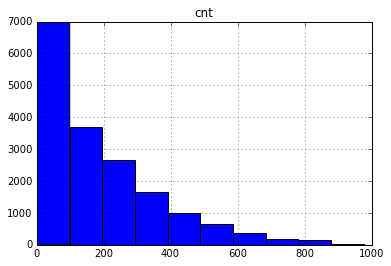

In [3]:
# Histogram of the cnt column of bike_rentals

import matplotlib.pyplot as plt

%matplotlib inline  
bike_rentals.hist(column = 'cnt')


The distribution is right skewed. The frequency of the bike rentals decreases as the count of bike rentals increases.

In [4]:
# Checking the Correlation of each column with cnt

corr_cnt = bike_rentals.corr()
corr_cnt['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [5]:
'''Function to convert hours into indicators -
1 if the hour is from 6 to 12
2 if the hour is from 12 to 18
3 if the hour is from 18 to 24
4 if the hour is from 0 to 6
'''

def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'].head(10)

0    4
1    4
2    4
3    4
4    4
5    4
6    1
7    1
8    1
9    1
Name: time_label, dtype: int64

### Error Metric

Mean Squared Error(MSE) can be the error metric we can use to evaluate the performance of our machine learning models. The cnt column is numeric and MSE works good for continuous data which fits our target column. 

In [6]:
# Splitting the data - 80% rows in train & 20% rows in test

train = bike_rentals.sample(frac = 0.8, random_state = 1)

# Index values for test dataset
train_index = bike_rentals.index.isin(train.index)

# Test data - Selecting any rows in bike_rentals that aren't found in train
test = bike_rentals.loc[~train_index]

### Applying Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

predictor_columns = train.columns
predictor_columns = predictor_columns.drop(['cnt','casual','dteday','registered'])

target_column = 'cnt'

lr = LinearRegression()

# Train the model
lr.fit(train[predictor_columns], train[target_column])

# Make predictions
lr_predictions = lr.predict(test[predictor_columns])

# Calculate error
lr_error = mean_squared_error(test[target_column],lr_predictions)

print(lr_error)


17052.124871247568


The error metric is very high. This is because of a few values in the cnt column for certain rows are very high when compared to the other, more frequent values. This kind of distribution has a higher impact on the MSE value. 

### Applying Decision Trees

Decision trees tend to predict outcomes much more reliably than linear regression models. 
- Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. 
- Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [22]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(min_samples_leaf = 7)

# Training the model
dt.fit(train[predictor_columns], train[target_column])

# Make Predictions
dt_predictions = dt.predict(test[predictor_columns])

# Calculate Error
dt_error = mean_squared_error(test[target_column],dt_predictions)

print(dt_error)


2580.99164565028


The error metric has reduced by a huge margin when we used the decision trees. By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

### Applying Random Forests

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees.

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 150,min_samples_leaf = 5)

# Train the model
rf.fit(train[predictor_columns], train[target_column])

# Make Predictions
rf_predictions = rf.predict(test[predictor_columns])

# Calculate Error
rf_error = mean_squared_error(test[target_column], rf_predictions)

print(rf_error)


2050.5369134273674


By using Random Forests algorithm, we could reduce the error metric even further. 

We can modeify the hyperparameter values such as n_estimators and min_samples_leaf to see the change in the error metric.

In [29]:
# Implement the RandomForests Algorithm with different n_estimators values

error_estimators = {}
n_estimators = [100, 150, 250]
for each in n_estimators:
    rf = RandomForestRegressor(n_estimators = each ,min_samples_leaf = 7)

    # Train the model
    rf.fit(train[predictor_columns], train[target_column])

    # Make Predictions
    rf_predictions = rf.predict(test[predictor_columns])

    # Calculate Error
    rf_error = mean_squared_error(test[target_column], rf_predictions)

    error_estimators[each] = rf_error
        
error_estimators


{100: 2138.7571024351746, 150: 2142.7164332533416, 250: 2129.5157095858376}

Using the n_estimators as 250 us the least error value. 

In [30]:
# Implement the RandomForests Algorithm with different min_samples_leaf values

error_samples = {}
for i in range(1,15):
    rf = RandomForestRegressor(n_estimators = 250 ,min_samples_leaf = i)

    # Train the model
    rf.fit(train[predictor_columns], train[target_column])

    # Make Predictions
    rf_predictions = rf.predict(test[predictor_columns])

    # Calculate Error
    rf_error = mean_squared_error(test[target_column], rf_predictions)

    error_samples[i] = rf_error
        
error_samples



{1: 1840.222567337169,
 2: 1848.6310140277212,
 3: 1911.0832991797013,
 4: 1974.4309053751826,
 5: 2029.8352374932863,
 6: 2091.104832847353,
 7: 2132.590067946611,
 8: 2203.454261737516,
 9: 2258.4762330068393,
 10: 2320.647930013898,
 11: 2384.4242525398927,
 12: 2448.389808045398,
 13: 2490.073976113713,
 14: 2548.071195180483}

The algorithm took quite some time to run for the various combinations of the hyper paramters. But, Random Forests is a great algorithm for regression and classification problems.

Using Random Forests, we make near correct predictions for the total number of bikes people rent in a given hour. 